In [5]:
pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/59/ed/548f6f686845d386a727a51a3daa411d95fc599649a2d54705f6773ac259/scikit_learn-1.3.1-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.3 MB 2.6 MB/s eta 0:00:04
   ----- ---------------------------------- 1.2/9.3 MB 13.2 MB/s eta 0:00:01
   ---------------- ----------------------- 3.9/9.3 MB 31.3 MB/s eta 0:00:01
   ---------------------------- ----------- 6.6/9.3 MB 38.2 MB/s eta 0:00:01
   ---------------------------------------  9.2/9.3 MB 42.4 MB/s eta 0:00:01
   ---------------------------------------- 9.3/9.3 MB 37.0 MB/s eta 0:00:00
Using cached threadpoolctl-3.2.0-p

In [6]:
import sqlite3 
import pandas as pd
import numpy as np
import seaborn as sns
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.ensemble import IsolationForest

In [7]:

# Connect to the database (or create it if it doesn't exist)
conn = sqlite3.connect('car_listings.db')

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

# Step 1: Update the make column
cursor.execute("""
    UPDATE car_listings
    SET 
        make = CASE 
            WHEN make = 'Aston' THEN 'Aston Martin'
            WHEN make = 'Alfa' THEN 'Alfa Romeo'
            ELSE make
        END,
        model = CASE
            WHEN make = 'Aston' AND model LIKE 'Martin %' THEN SUBSTR(model, INSTR(model, 'Martin ') + 7)
            WHEN make = 'Alfa' AND model LIKE 'Romeo %' THEN SUBSTR(model, INSTR(model, 'Romeo ') + 6)
            ELSE model
        END
""")

# Commit the changes to the database
conn.commit()

# Close the connection
conn.close()

In [8]:
import sqlite3
import csv

# Connect to the SQLite database
conn = sqlite3.connect('car_listings.db')
cursor = conn.cursor()

# Execute a query to retrieve all data from the desired table
cursor.execute("SELECT * FROM car_listings")
rows = cursor.fetchall()

# Define the CSV file name
csv_filename = 'car_listings.csv'

# Write data to a CSV file
with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    # Write the header (column names)
    csv_writer.writerow([description[0] for description in cursor.description])
    # Write the data rows
    csv_writer.writerows(rows)

# Close the SQLite connection
conn.close()


In [9]:
cars_db = pd.read_csv("car_listings.csv")

In [12]:
# Checking the columns present in the data
cars_db.columns

Index(['id', 'timestamp', 'make', 'model', 'year', 'mileage', 'listing_price',
       'url'],
      dtype='object')

In [13]:
# Checking the first 5 rows of the dataset
cars_db.head()

,id,timestamp,make,model,year,mileage,listing_price,url
0,1,2023-09-29 11:00,BMW,X5 xDrive35d,2012,110211,111749900,https://www.cars.com/vehicledetail/eee1532c-ef...
1,2,2023-09-29 11:00,Ferrari,LaFerrari Base,2015,818,4350000,https://www.cars.com/vehicledetail/5ebcb7e4-af...
2,3,2023-09-29 11:00,Ferrari,LaFerrari Base,2014,2758,4099991,https://www.cars.com/vehicledetail/60494e12-b3...
3,4,2023-09-29 11:00,Bugatti,Chiron,2018,4064,3799999,https://www.cars.com/vehicledetail/85c3e645-07...
4,5,2023-09-29 11:00,Bugatti,Chiron,2018,1080,3575000,https://www.cars.com/vehicledetail/c7afc3bd-b8...


In [14]:
# Understand the shape of the data
cars_db.shape

(1089, 8)

In [15]:
# Extracting basic info about the dataframe.
cars_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1089 non-null   int64 
 1   timestamp      1089 non-null   object
 2   make           1089 non-null   object
 3   model          1089 non-null   object
 4   year           1089 non-null   int64 
 5   mileage        1089 non-null   int64 
 6   listing_price  1089 non-null   int64 
 7   url            1089 non-null   object
dtypes: int64(4), object(4)
memory usage: 68.2+ KB


In [16]:
# checking if the data has null values present.
cars_db.isnull().sum()

id               0
timestamp        0
make             0
model            0
year             0
mileage          0
listing_price    0
url              0
dtype: int64

In [18]:
# Checking the Dataframe for duplicate values in each column.
list_columns = cars_db.columns

for column in list_columns:
    number_of_duplicates = cars_db[column].duplicated().sum()
    print(f'Number of duplicates in column {column}: {number_of_duplicates}')

Number of duplicates in column id: 0
Number of duplicates in column timestamp: 1054
Number of duplicates in column make: 1062
Number of duplicates in column model: 872
Number of duplicates in column year: 1048
Number of duplicates in column mileage: 114
Number of duplicates in column listing_price: 388
Number of duplicates in column url: 0


In [19]:
# Checking the count of unique values in each column
cars_db.nunique()

id               1089
timestamp          35
make               27
model             217
year               41
mileage           975
listing_price     701
url              1089
dtype: int64

In [20]:
# calling a describe method to get some insight on different aspects of the data.
cars_db.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1089.0,NaN,NaN,NaN,553.785124,314.877774,1.0,282.0,554.0,826.0,1098.0
timestamp,1089,35,2023-10-02 00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
make,1089,27,Ferrari,448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,1089,217,Cullinan,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,1089.0,NaN,NaN,NaN,2018.966942,7.552075,1950.0,2019.0,2021.0,2022.0,2024.0
mileage,1089.0,NaN,NaN,NaN,5086.597796,14305.397472,10.0,612.0,1927.0,4780.0,207316.0
listing_price,1089.0,NaN,NaN,NaN,708411.24977,3427263.426324,374000.0,409895.0,479000.0,629900.0,111749900.0
url,1089,1089,https://www.cars.com/vehicledetail/eee1532c-ef...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# getting some of the same info as the .descrive function for the categorical values.
cars_db.describe(include=object).T

,count,unique,top,freq
timestamp,1089,35,2023-10-02 00:00,71
make,1089,27,Ferrari,448
model,1089,217,Cullinan,73
url,1089,1089,https://www.cars.com/vehicledetail/eee1532c-ef...,1


In [22]:
# Drop the 'timestamp' column
cars_db_1 = cars_db.drop(columns='timestamp')

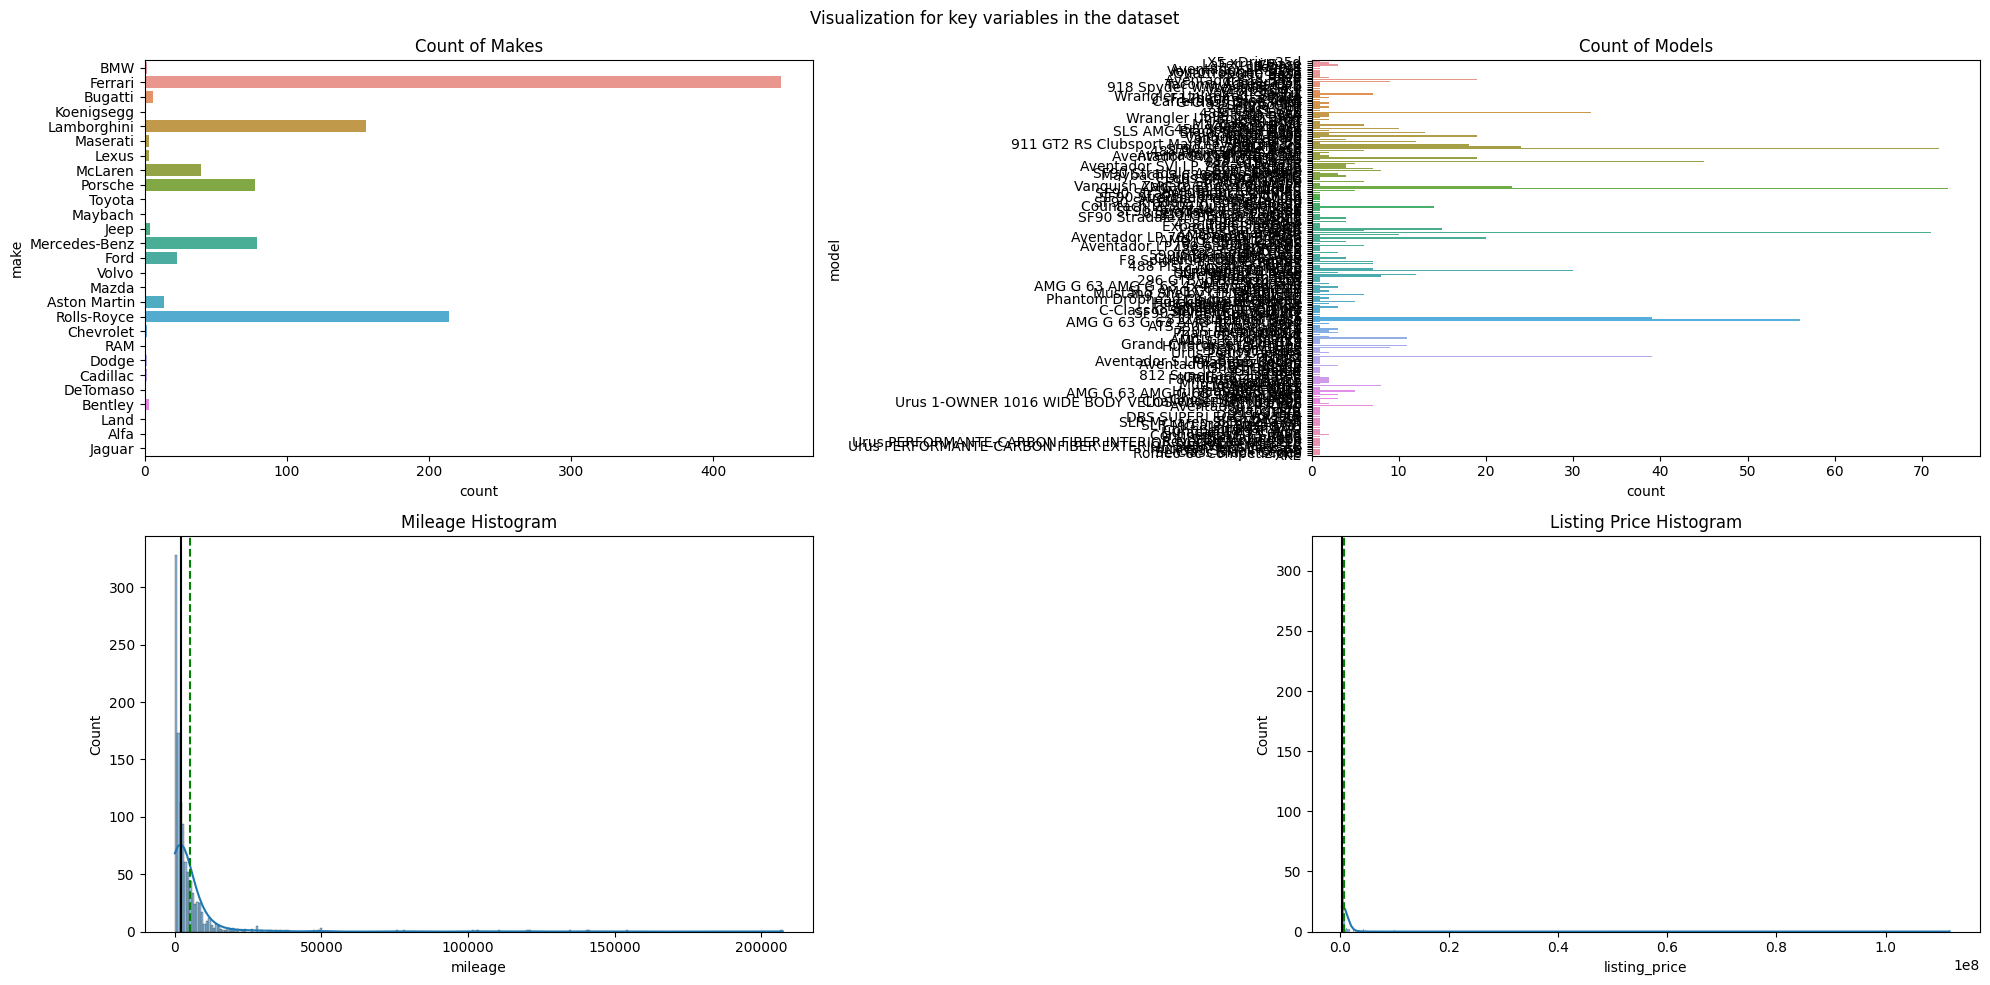

In [29]:

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Visualization for key variables in the dataset')

plot_titles = ['Count of Makes', 'Count of Models', 'Mileage Histogram', 'Listing Price Histogram']
plot_features = ['make', 'model', 'mileage', 'listing_price']

for i, ax in enumerate(axes.flatten()):
    feature = plot_features[i]
    if feature in ['make', 'model']:
        sns.countplot(y=feature, data=cars_db_1, ax=ax)  # Changed to countplot for categorical data
    else:
        sns.histplot(x=feature, data=cars_db_1, kde=True, ax=ax)
        ax.axvline(cars_db_1[feature].mean(), color="green", linestyle="--")
        ax.axvline(cars_db_1[feature].median(), color="black", linestyle="-")
    ax.set_title(plot_titles[i])

plt.subplots_adjust(top=0.9)  # Adjusts the space to prevent title overlapping
plt.tight_layout()
plt.show()


id
Skew : -0.0


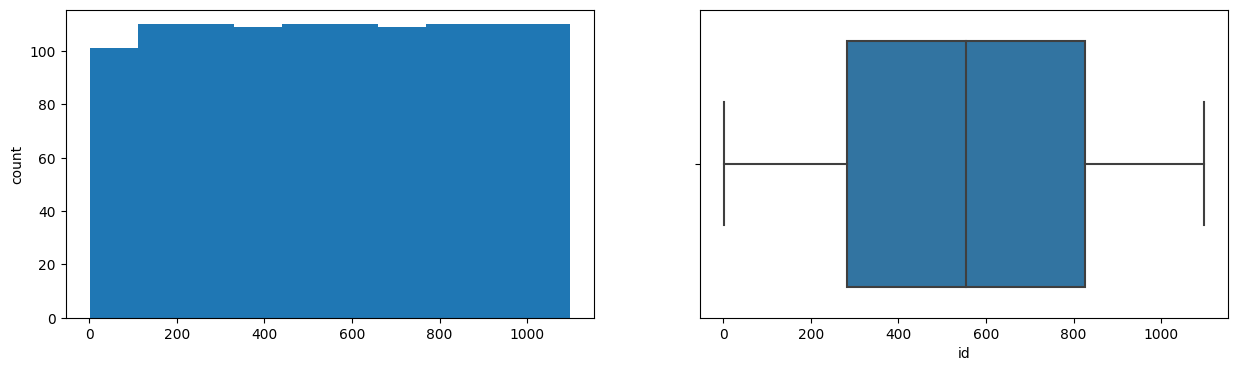

year
Skew : -4.61


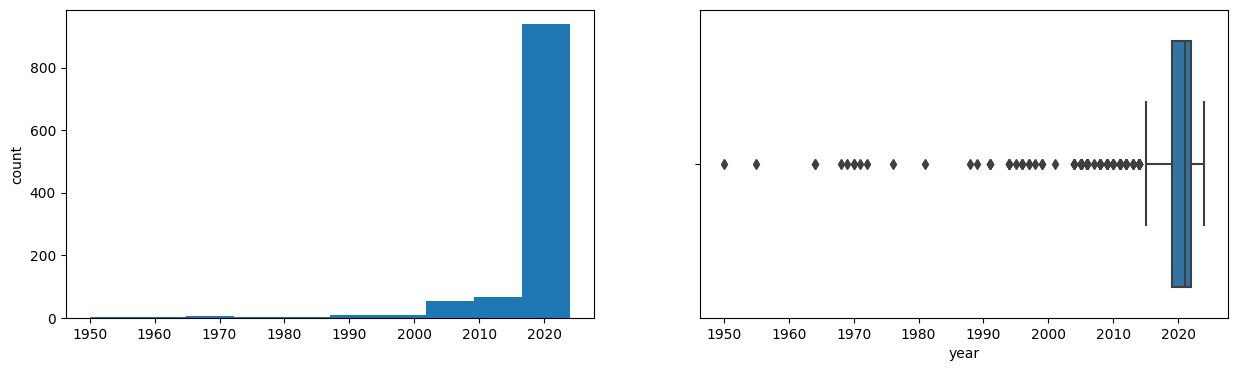

mileage
Skew : 8.3


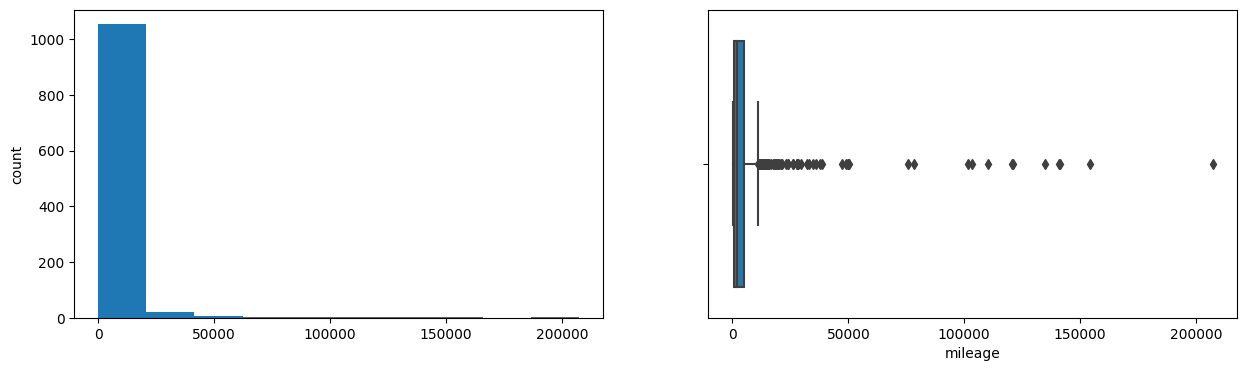

listing_price
Skew : 31.4


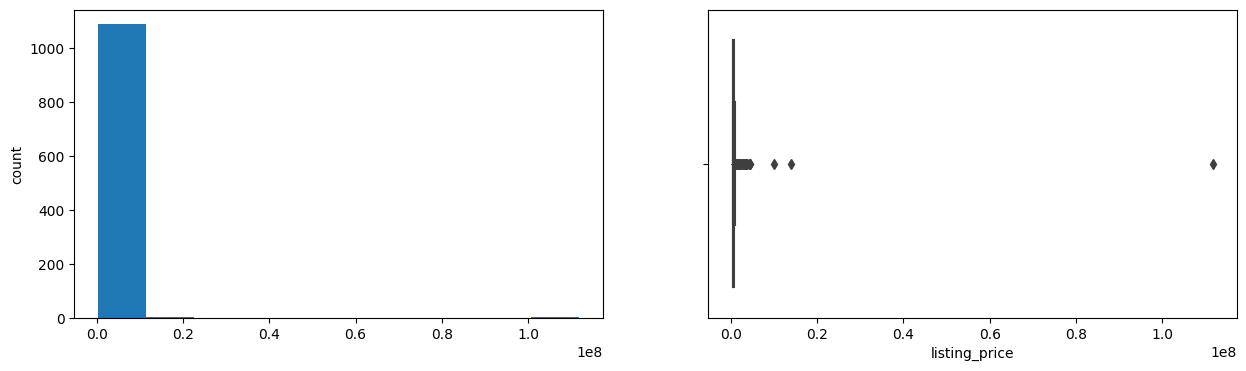

In [30]:
# Plotting some boxplots to identify possible outliers.

result = cars_db_1.select_dtypes(include = 'number')

cont_cols = list(result)

for col in cont_cols:

    print(col)
    
    print('Skew :',round(cars_db_1[col].skew(),2))
    
    plt.figure(figsize = (15, 4))
    
    plt.subplot(1, 2, 1)
    
    cars_db_1[col].hist(bins = 10, grid = False)
    
    plt.ylabel('count')
    
    plt.subplot(1, 2, 2)
    
    sns.boxplot(x = cars_db_1[col])
    
    plt.show()

In [31]:
# finding the 'kilometers_driven' outlier index value
cars_db_1.sort_values('listing_price', ascending=False, na_position='last') 

,id,make,model,year,mileage,listing_price,url
0,1,BMW,X5 xDrive35d,2012,110211,111749900,https://www.cars.com/vehicledetail/eee1532c-ef...
535,545,Mercedes-Benz,C-Class C 300 4MATIC Luxury,2016,103150,13990000,https://www.cars.com/vehicledetail/426f89c8-ce...
536,546,Chevrolet,Silverado 1500 2LT,2018,120518,9999999,https://www.cars.com/vehicledetail/66e6f80b-a9...
1,2,Ferrari,LaFerrari Base,2015,818,4350000,https://www.cars.com/vehicledetail/5ebcb7e4-af...
287,297,Ford,Expedition Platinum,2018,49754,4343569,https://www.cars.com/vehicledetail/10567512-de...
...,...,...,...,...,...,...,...
1081,1091,Ferrari,F8 Tributo Base,2022,2600,374900,https://www.cars.com/vehicledetail/11dce41f-34...
1085,1095,Lamborghini,Huracan STO Base,2022,373,374727,https://www.cars.com/vehicledetail/dbdcde1f-5d...
1086,1096,Rolls-Royce,Ghost,2021,4964,374500,https://www.cars.com/vehicledetail/60e8db8a-34...
1087,1097,Rolls-Royce,Ghost,2022,5235,374007,https://www.cars.com/vehicledetail/696b58bc-b8...


In [34]:
# Dropping the extreme outlier in 'Kilometers_driven' and the whole 'S.No.' column creating a new DF.
cars_db_2 = cars_db_1.drop(labels=[0,287,535,536], axis=0)

In [35]:
# finding the 'kilometers_driven' outlier index value
cars_db_2.sort_values('listing_price', ascending=False, na_position='last') 

,id,make,model,year,mileage,listing_price,url
1,2,Ferrari,LaFerrari Base,2015,818,4350000,https://www.cars.com/vehicledetail/5ebcb7e4-af...
2,3,Ferrari,LaFerrari Base,2014,2758,4099991,https://www.cars.com/vehicledetail/60494e12-b3...
3,4,Bugatti,Chiron,2018,4064,3799999,https://www.cars.com/vehicledetail/85c3e645-07...
4,5,Bugatti,Chiron,2018,1080,3575000,https://www.cars.com/vehicledetail/c7afc3bd-b8...
5,6,Koenigsegg,Regera,2021,503,3500000,https://www.cars.com/vehicledetail/acfa20ea-3c...
...,...,...,...,...,...,...,...
1084,1094,Jaguar,XKE,1964,248,374900,https://www.cars.com/vehicledetail/2e8d6e72-84...
1085,1095,Lamborghini,Huracan STO Base,2022,373,374727,https://www.cars.com/vehicledetail/dbdcde1f-5d...
1086,1096,Rolls-Royce,Ghost,2021,4964,374500,https://www.cars.com/vehicledetail/60e8db8a-34...
1087,1097,Rolls-Royce,Ghost,2022,5235,374007,https://www.cars.com/vehicledetail/696b58bc-b8...


Skew : 5.48


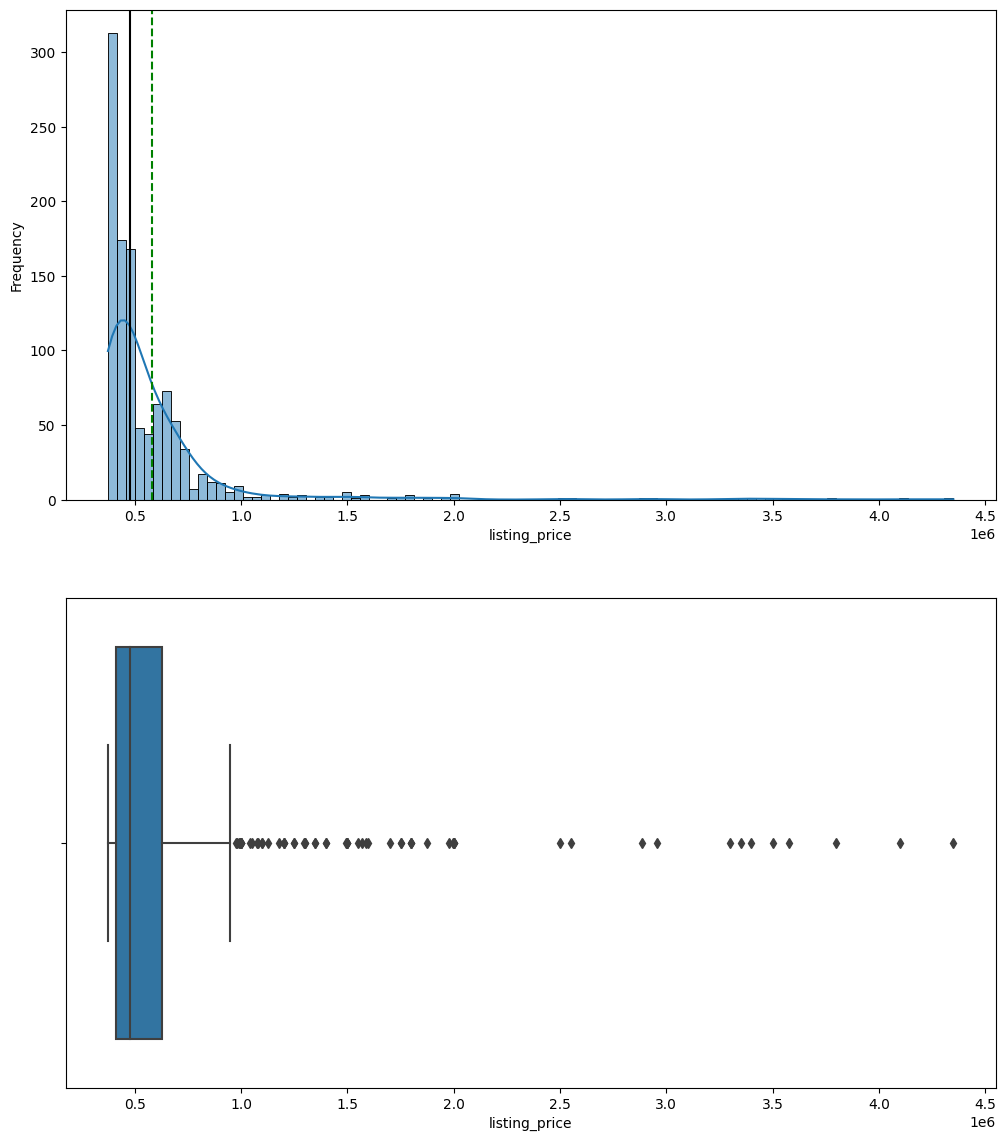

In [37]:
# Replotting the histograms for 'lisitng_price' after dropping the outliers

fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# Histogram
sns.histplot(x='listing_price', data=cars_db_2, kde=True, ax=axes[0])
print('Skew :',round(cars_db_2[col].skew(),2))
axes[0].axvline(cars_db_2['listing_price'].mean(), color="green", linestyle="--")
axes[0].axvline(cars_db_2['listing_price'].median(), color="black", linestyle="-")
axes[0].set_xlabel('listing_price')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x='listing_price', data=cars_db_2, ax=axes[1])
axes[1].set_xlabel('listing_price')
axes[1].set_ylabel('')

plt.show()

In [38]:
# Reseting index in order to update the dropped rows.
cars_db_2 = cars_db_2.reset_index(drop = True)

In [41]:
cars_db_2['make'].unique()

array(['Ferrari', 'Bugatti', 'Koenigsegg', 'Lamborghini', 'Maserati',
       'Lexus', 'McLaren', 'Porsche', 'Toyota', 'Maybach', 'BMW', 'Jeep',
       'Mercedes-Benz', 'Ford', 'Volvo', 'Mazda', 'Aston Martin',
       'Rolls-Royce', 'Chevrolet', 'RAM', 'Dodge', 'Cadillac', 'DeTomaso',
       'Bentley', 'Land', 'Alfa', 'Jaguar'], dtype=object)

In [48]:
# List of makes to filter
selected_makes = ["Toyota", "BMW", "Jeep", "Volvo", "Ford", "Mazda", "Chevrolet", "RAM", "Land"]

# Filter the DataFrame
filtered_cars_db_2 = cars_db_2[cars_db_2['make'].isin(selected_makes)]
print(filtered_cars_db_2.head(50))

        id       make                        model  year  mileage  \
14      16     Toyota            Tacoma Access Cab  2010   141416   
21      23        BMW                       750 iL  1996   121043   
25      36       Jeep    Wrangler Unlimited Sahara  2013   154194   
37      48       Ford                           GT  2020       24   
50      61       Jeep     Wrangler Unlimited Sport  2015    47065   
51      62       Ford                 F-150 Lariat  2017   101655   
52      63      Volvo                    XC60 3.0T  2010   207316   
53      64      Mazda               Mazda6 Touring  2019   140713   
202    213  Chevrolet                 Corvette L88  1969    14617   
228    239       Ford                      GT Base  2006     2196   
350    362       Ford                      GT Base  2006       95   
353    365        RAM                     1500 TRX  2021     2800   
363    375       Ford             Mustang Boss 429  1970    16799   
379    391       Ford             

In [90]:
# Find the indices of the rows you want to drop
indices_to_drop = cars_db_2.index[cars_db_2['id'].isin([10, 11, 16, 23, 36, 61, 62, 63, 64, 365, 503, 598, 613, 644, 1057])]

# Drop these indices from the DataFrame
cars_db_3 = cars_db_2.drop(indices_to_drop)

In [91]:
# List of makes to filter
selected_makes = ["Toyota", "BMW", "Jeep", "Volvo", "Ford", "Mazda", "Chevrolet", "RAM", "Land"]

# Filter the DataFrame
filtered_cars_db_3 = cars_db_3[cars_db_3['make'].isin(selected_makes)]
print(filtered_cars_db_3.head(50))

        id       make                        model  year  mileage  \
37      48       Ford                           GT  2020       24   
202    213  Chevrolet                 Corvette L88  1969    14617   
228    239       Ford                      GT Base  2006     2196   
350    362       Ford                      GT Base  2006       95   
363    375       Ford             Mustang Boss 429  1970    16799   
379    391       Ford                      GT Base  2005     2517   
406    418       Ford                      GT Base  2006      572   
434    446       Ford                      GT Base  2005      624   
445    457       Ford                      GT Base  2006     1348   
465    477       Ford                           GT  2005      159   
466    478       Ford  Mustang Shelby GT Shelby GT  1968     9627   
492    504       Ford                      GT Base  2006       27   
507    519       Ford                      GT Base  2005      476   
586    600       Ford             

In [113]:
# Reseting index in order to update the dropped rows.
cars_db_3 = cars_db_3.reset_index(drop = True)

cars_db_3['make'].unique()

array(['Ferrari', 'Bugatti', 'Koenigsegg', 'Lamborghini', 'McLaren',
       'Porsche', 'Maybach', 'Mercedes-Benz', 'Ford', 'Lexus',
       'Aston Martin', 'Rolls-Royce', 'Chevrolet', 'Dodge', 'Cadillac',
       'Maserati', 'DeTomaso', 'Bentley', 'Alfa', 'Jaguar'], dtype=object)

In [114]:
cars_db_3

,id,make,model,year,mileage,listing_price,url
0,2,Ferrari,LaFerrari Base,2015,818,4350000,https://www.cars.com/vehicledetail/5ebcb7e4-af...
1,3,Ferrari,LaFerrari Base,2014,2758,4099991,https://www.cars.com/vehicledetail/60494e12-b3...
2,4,Bugatti,Chiron,2018,4064,3799999,https://www.cars.com/vehicledetail/85c3e645-07...
3,5,Bugatti,Chiron,2018,1080,3575000,https://www.cars.com/vehicledetail/c7afc3bd-b8...
4,6,Koenigsegg,Regera,2021,503,3500000,https://www.cars.com/vehicledetail/acfa20ea-3c...
...,...,...,...,...,...,...,...
1065,1094,Jaguar,XKE,1964,248,374900,https://www.cars.com/vehicledetail/2e8d6e72-84...
1066,1095,Lamborghini,Huracan STO Base,2022,373,374727,https://www.cars.com/vehicledetail/dbdcde1f-5d...
1067,1096,Rolls-Royce,Ghost,2021,4964,374500,https://www.cars.com/vehicledetail/60e8db8a-34...
1068,1097,Rolls-Royce,Ghost,2022,5235,374007,https://www.cars.com/vehicledetail/696b58bc-b8...


Text(0, 0.5, 'listing_price')

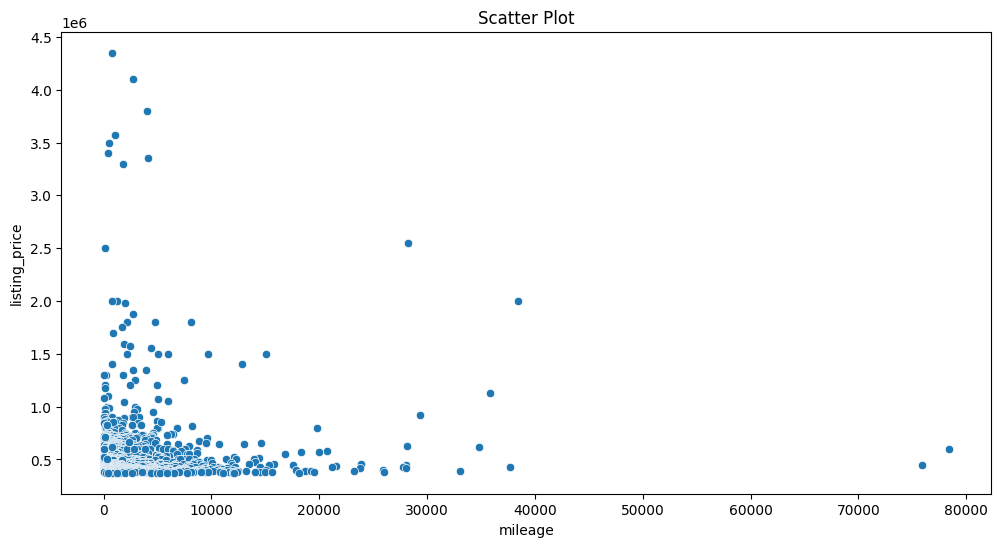

In [94]:
plt.figure(figsize=(12, 6))

# Scatter plot - cars_df_1
sns.scatterplot(x='mileage', y='listing_price', data=cars_db_3)
plt.title('Scatter Plot')
plt.xlabel('mileage')
plt.ylabel('listing_price')

In [95]:
# finding the 'kilometers_driven' outlier index value
cars_db_3.sort_values('mileage', ascending=False, na_position='last') 

,id,make,model,year,mileage,listing_price,url
525,550,Ferrari,Dino 246 GT,1972,78416,599900,https://www.cars.com/vehicledetail/f153dc90-d1...
588,615,Ferrari,Dino,1971,75916,450990,https://www.cars.com/vehicledetail/c7037886-8d...
12,17,Maybach,Type 62 S,2012,38468,1999000,https://www.cars.com/vehicledetail/b5100eeb-e4...
668,696,Ferrari,365,1976,37645,429999,https://www.cars.com/vehicledetail/62de1cab-77...
39,55,Porsche,Carrera GT,2004,35824,1125000,https://www.cars.com/vehicledetail/c3192c9a-5c...
...,...,...,...,...,...,...,...
463,485,Mercedes-Benz,AMG G 63 4x4 Squared,2023,18,489998,https://www.cars.com/vehicledetail/c5bb22b2-61...
290,311,Mercedes-Benz,AMG G 63 4MATIC,2023,14,599950,https://www.cars.com/vehicledetail/31104a90-0a...
371,393,Porsche,911 GT3 RS,2023,12,529998,https://www.cars.com/vehicledetail/d076e2b0-9e...
886,914,Mercedes-Benz,AMG G 63 4MATIC,2023,10,398950,https://www.cars.com/vehicledetail/b1ade5e3-62...


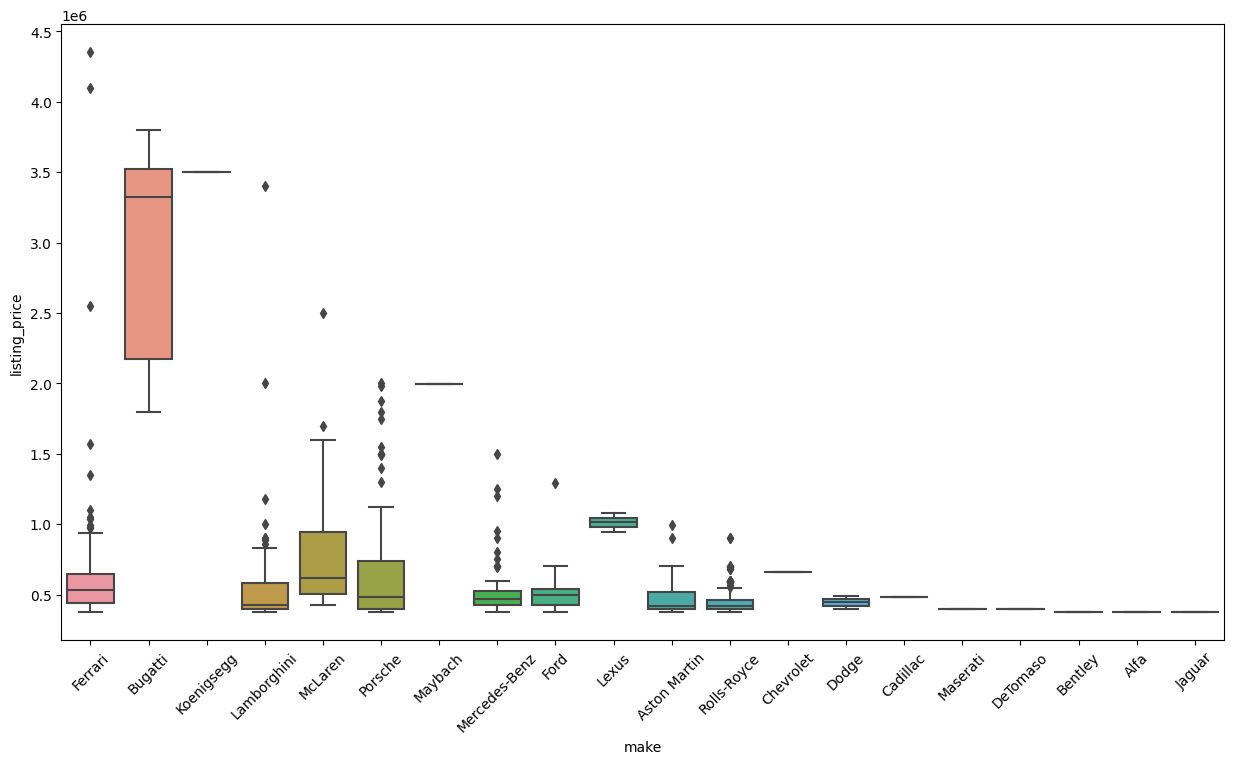

In [96]:
# Set the figure size
plt.figure(figsize = (15, 8))

# Create the boxplots
sns.boxplot(x = cars_db_3['make'], y = cars_db_3['listing_price'])
# Rotate the labels on the x-axis to 45 degrees
plt.xticks(rotation=45)

plt.show()

In [102]:
cars_db_3[cars_db_3['make'] == 'Jaguar']

,id,make,model,year,mileage,listing_price,url
1065,1094,Jaguar,XKE,1964,248,374900,https://www.cars.com/vehicledetail/2e8d6e72-84...


In [116]:
# Saving a new cured CSV
cars_db_3.to_csv('car_listings_cured.csv', index=False)